In [25]:
import pandas as pd
import numpy  
import tensorflow as tf
import math
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
configpartno='85-EKA0190'

In [26]:
def readTrain():
    train =  pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
    train= train[train['PART_NO']==configpartno]  
    train.drop(columns=['PART_NO','EQP_NO','MFG_MONTH','PM','TS','ENG','NST'],inplace=True)
    train.groupby(['STOCK_EVENT_TIME']).sum().reset_index()
    print(train)
    return train

In [27]:
# LSTM for international airline passengers problem with regression framing

# 產生 (X, Y) 資料集, Y 是下一期的乘客數
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]  # X1 : ([0:1],0) Y1:(1:0)   ,([1:2],0)
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [28]:
# dataframe[dataframe['STOCK_EVENT_TIME'] > '2021-01-01']]
 
# print(dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')].shape)
# print(dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape)

In [29]:

# 載入訓練資料
#dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = readTrain()
dataset = dataframe['QTY']
dataset = dataset.astype('float32')

     STOCK_EVENT_TIME  QTY
3150        2015/1/31    0
3151        2015/2/28    0
3152        2015/3/31    0
3153        2015/4/30    0
3154        2015/5/31    0
...               ...  ...
3745       2020/11/30   15
3746       2020/12/31   20
3747        2021/1/31   15
3748        2021/2/28    5
3749        2021/3/31   15

[600 rows x 2 columns]


In [30]:
dataset =dataset.values.reshape(-1,1)

In [31]:

# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [32]:
# 2/3 資料為訓練資料， 1/3 資料為測試資料
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size

train_size = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape[0]
# test_size =  dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape[0]
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的乘客數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [65]:
# # numpy.savetxt("dataset.csv", dataset, delimiter=",")
# numpy.savetxt("testY.csv", testY, delimiter=",")
# _train =  pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
# _train= _train[_train['PART_NO']==configpartno]  
# _train.drop(columns=['PART_NO','EQP_NO','MFG_MONTH','PM','TS','ENG','NST'],inplace=True)
# _train.groupby(['STOCK_EVENT_TIME']).sum().reset_index()
# _train.sort_values('STOCK_EVENT_TIME')
# _train.to_csv('raw.csv')

In [54]:
print(train_size,test_size)
print(trainX.shape,testX.shape)

576 24
(574, 1, 1) (22, 1, 1)


In [34]:
dataframe

,STOCK_EVENT_TIME,QTY
3150,2015/1/31,0
3151,2015/2/28,0
3152,2015/3/31,0
3153,2015/4/30,0
3154,2015/5/31,0
...,...,...
3745,2020/11/30,15
3746,2020/12/31,20
3747,2021/1/31,15
3748,2021/2/28,5


In [35]:

# 建立及訓練 LSTM 模型
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=4, input_shape=(1, look_back)),
            tf.keras.layers.Dense(units=1),
            ]) 
model.compile(loss='mean_squared_error', 
            optimizer=tf.keras.optimizers.Adam(),
            # metrics=[tf.keras.metrics.MeanAbsoluteError()]
            ) 
model.summary()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 574 samples
Epoch 1/100
574/574 - 4s - loss: 0.0401
Epoch 2/100
574/574 - 1s - loss: 0.0169
Epoch 3/100
574/574 - 1s - loss: 0.0122
Epoch 4/100
574/574 - 1s - loss: 0.0117
Epoch 5/100
574/574 - 1s - loss: 0.0116
Epoch 6/100
574/574 - 1s - loss: 0.0116
Epoch 7/100
574/574 - 1s - loss: 0.0116
Epoch 8/100
574/574 - 1s - loss: 0.0116
Epoch 9/100
574/574 - 1s - loss: 0.0116
Epoch 10/100
574/574 - 1s - loss: 0.0116
Epoch 11/100
574/574 - 1s - loss: 0.0117
Epoch 12/100
574/574 - 1s - loss: 0.0117
Epoch 13/100
5

In [36]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [37]:
# nsamples, nx, ny = train_dataset.shape
# d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

In [38]:

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)

In [39]:
trainY = scaler.inverse_transform([trainY])

In [40]:

testPredict = scaler.inverse_transform(testPredict)

In [41]:


testY = scaler.inverse_transform([testY])

In [42]:
#calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.16 RMSE
Test Score: 8.78 RMSE


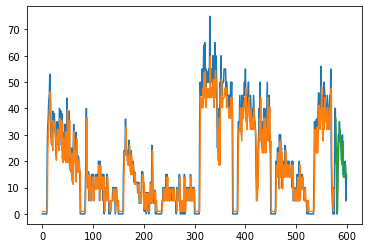

In [43]:

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset) #返回形狀和類型與給定數組相同的新數組。
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [53]:
testPredictPlot

array([[        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [  

In [44]:


# trainPredictPlot[np.isnan(trainPredictPlot)] = 0  # replace all nan in a with 0
# testPredictPlot[np.isnan(testPredictPlot)] = 0  # replace all nan in b with 0
# numpy.add(trainPredictPlot, testPredictPlot) 
# dataframe_test = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')]
dataframe_test = dataframe.copy(deep = False)

In [45]:
dataframe_test['Predict'] = testPredictPlot

In [46]:
dataframe_test =  dataframe_test[dataframe_test['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')]

In [47]:
def accsum(def_result,target_cols):
        _accsum=0 
        for index,row in def_result.iterrows():
            #避免當分母為0 會無法計算
            if row[target_cols]==0 and row['Predict']==0 :
                row[target_cols] =1
                row['Predict'] =1
            elif row[target_cols] ==0 and row['Predict']!=0:
                row[target_cols]  =0.00001

            if row[target_cols] <0 :
                row[target_cols]  =0.00001

            if row['Predict'] <0 :
                row['Predict']  =0 

            if 1- abs((row['Predict'] - row[target_cols])/row[target_cols] ) >0 : 
                _accsum+=(1- abs((row['Predict'] - row[target_cols])/row[target_cols] ))
        
        return round(_accsum*100/def_result.shape[0],2)

In [48]:
accsum(dataframe_test,'QTY')

3.19